In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score
from RFBDoSBC.GetAndPrepareData import *
from RFBDoSBC.modelPreparation import *
from RFBDoSBC.modelEvaluation import *
from RFBDoSBC.plotData import *
from RFBDoSBC.utility import *


In [2]:
R = [0.2, 0.3, 0.4, 0.5, 0.6]
pThardmin = [10,20,30,40]
rad = R[2]
ptm = pThardmin[0]

In [3]:
msg("Analyzing jets with R=%1.1f and p_T hardmin=%d"%(rad, ptm))


JEB: Analyzing jets with R=0.4 and p_T hardmin=10


In [4]:
best_params = loadBestParameters(rad, ptm)
best_params_lowpt = loadBestParameters(rad, ptm, True)
rfModel = [makeRandomForest(best_params) for _ in range(3)]
rfModelLowpt = [makeRandomForest(best_params_lowpt) for _ in range(3)]

batch_num = 0
feat_imp = {}

In [5]:
print(best_params_lowpt)

{'n_estimators': 200, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'max_features': 'auto', 'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.0, 'max_samples': 0.9, 'oob_score': True, 'random_state': 42, 'n_jobs': -1, 'class_weight': {1: 1, 2: 1, 3: 4}}


In [6]:
dataGen = DataPipelineBatch(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, True, False)




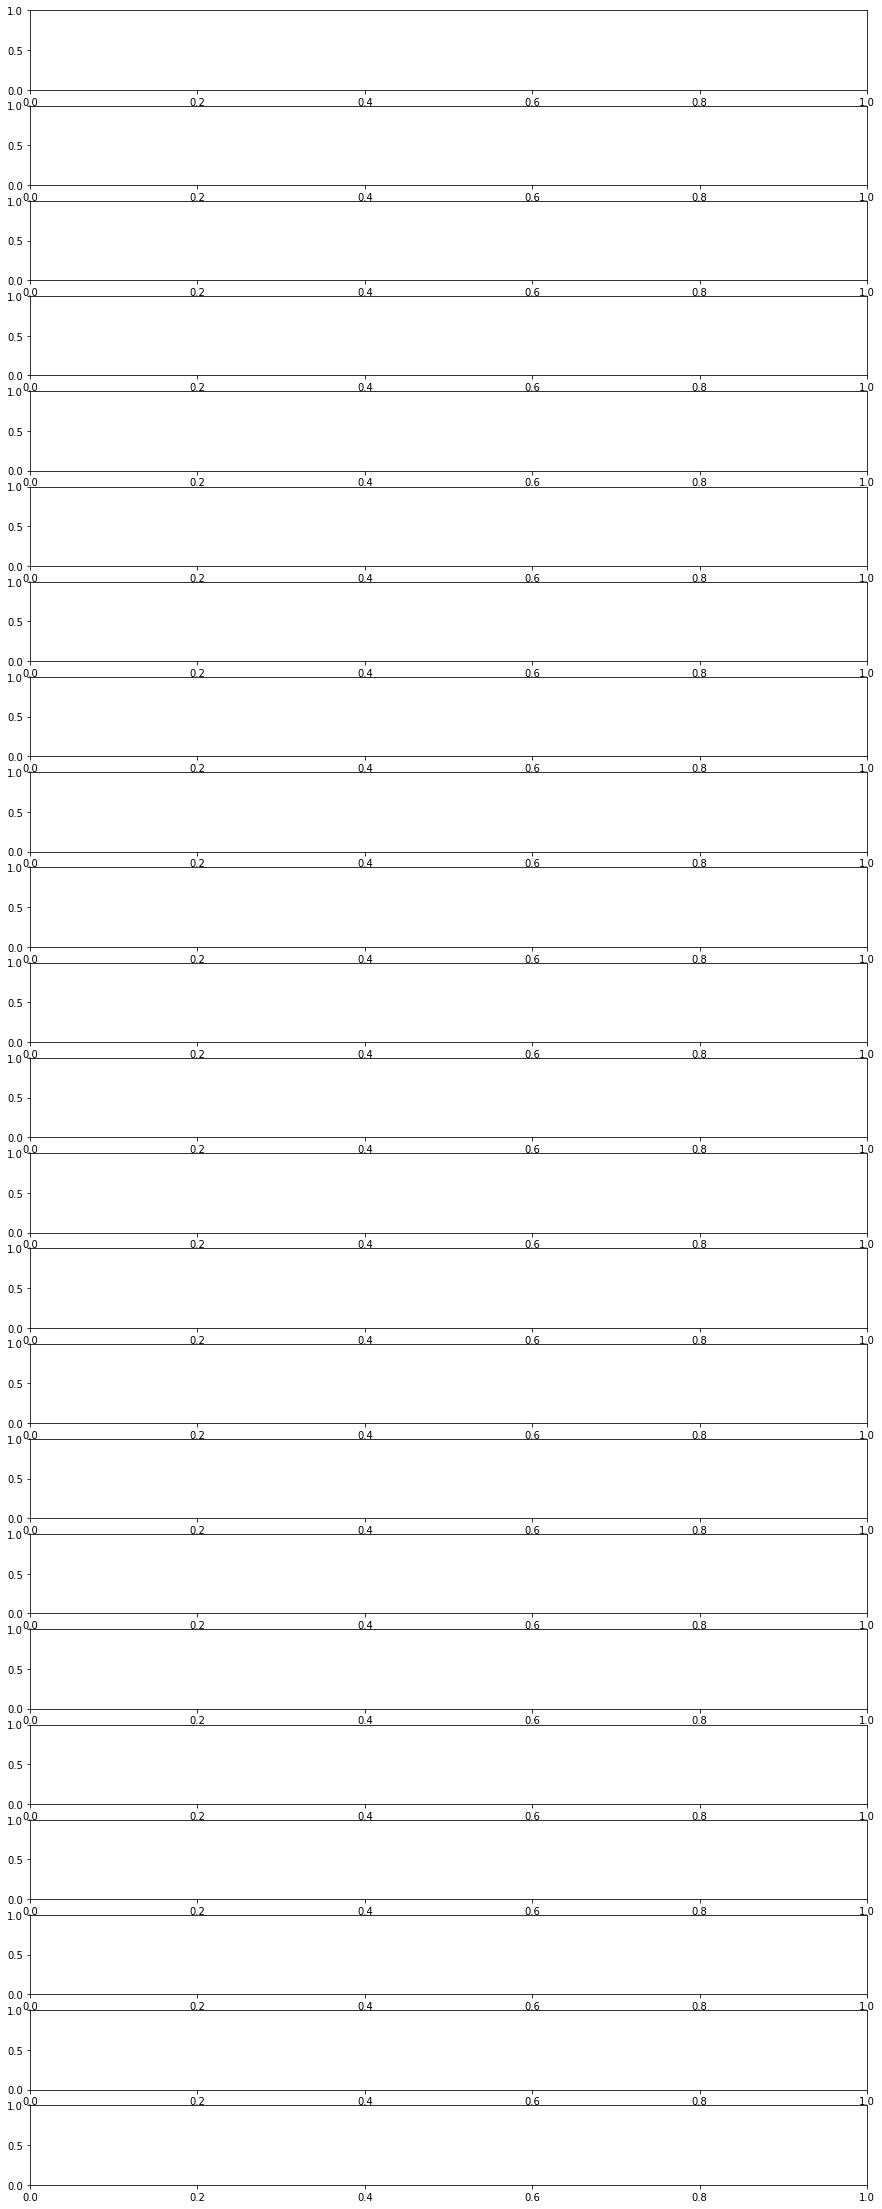

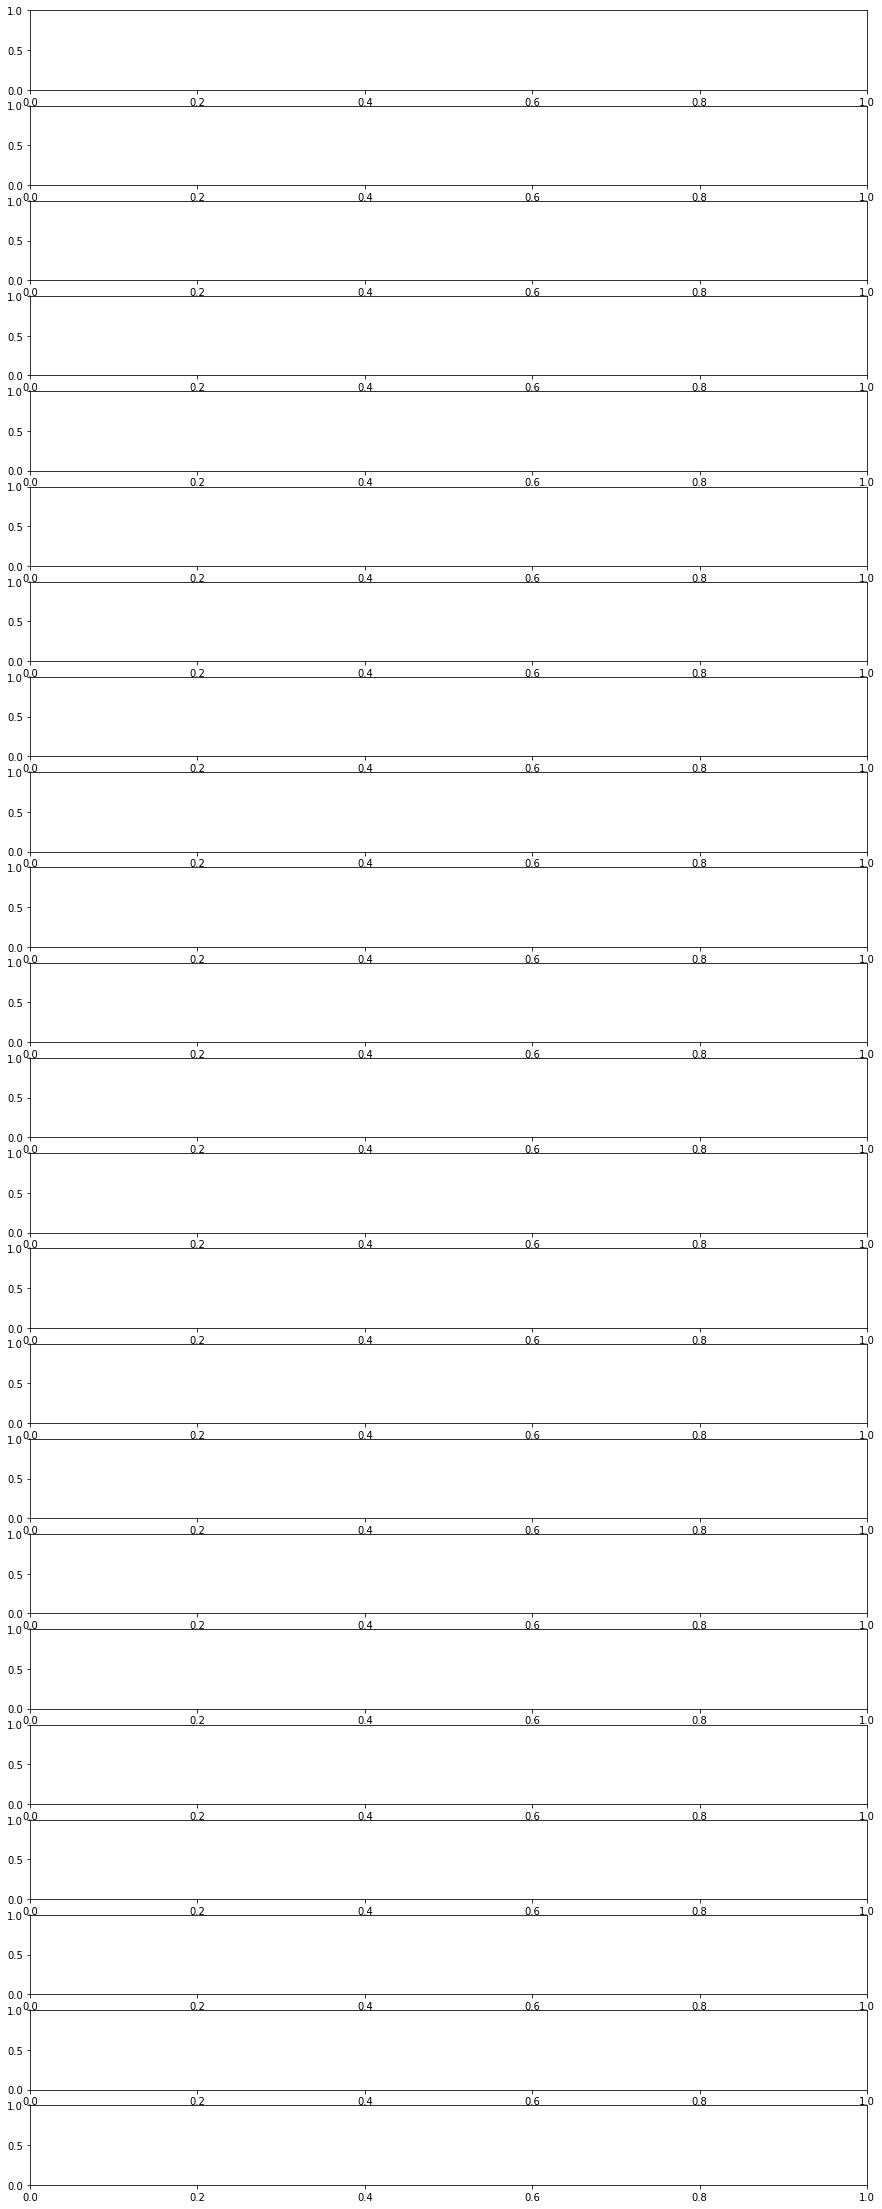

In [7]:
fig, ax = plt.subplots(8+15, 1, figsize=(15,40));
fig1, ax1 = plt.subplots(8+15, 1, figsize=(15,40));


In [8]:
do_plotting = False


while batch_num<3:
    print(f"Doing batch_num {batch_num}")
    
    train, test = next(dataGen)
    trainLowpt = train.loc[train['p_T']<100]

    i=0

    X, Y = split_feat_label(train)
    XLowpt, YLowpt = split_feat_label(trainLowpt)

    rfModel[batch_num] = doRandomForestFit(X, Y, rfModel[batch_num], batch_num)
    rfModelLowpt[batch_num] = doRandomForestFit(XLowpt, YLowpt, rfModelLowpt[batch_num], batch_num)

    if do_plotting:
        print("Plotting...")
        for feat in train.columns:

            if feat in ['p_T', 'Label_Name']:
                continue
            sns.scatterplot(data=train, x='p_T',y=feat, hue='Label_Name',hue_order=["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"], alpha=0.05, ax=ax[i])
            ax[i].legend([],[])
            i+=1


        i=0

        for feat in train.columns:
            if feat in ['p_T', 'Label_Name']:
                continue
            sns.scatterplot(data=trainLowpt, x='p_T',y=feat, hue='Label_Name',hue_order=["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"], alpha=0.05, ax=ax1[i])
            ax1[i].legend([],[])
            i+=1

    batch_num+=1
fig.legend(["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"])
fig1.legend(["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"])



Doing batch_num 0
JEB: Fitting to data for batch 0.
JEB: Fitting to data for batch 0.
Doing batch_num 1
JEB: Fitting to data for batch 1.
JEB: Fitting to data for batch 1.
Doing batch_num 2
JEB: Fitting to data for batch 2.
JEB: Fitting to data for batch 2.


In [9]:
train, test = DataPipeline(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, 20000000, True)
trainLowpt = train.loc[train['p_T']<100]

X, Y = split_feat_label(train)

XLowpt, YLowpt = split_feat_label(trainLowpt)


In [10]:
oracle = doOracleFit(X, rfModel, rad, ptm)
oracleLowpt = doOracleFit(XLowpt, rfModelLowpt, rad, ptm, True)

JEB: Initializing Oracle and fitting to rfModel's predictions
(3, 1306236) [[1 3 1 ... 2 1 1]
 [1 3 1 ... 2 1 1]
 [1 2 1 ... 2 1 1]]
(1306236,) 0          1
1          3
2          1
3          3
4          3
          ..
1306231    1
1306232    3
1306233    2
1306234    1
1306235    1
Length: 1306236, dtype: int64
[1 2 3]
JEB: Initializing Oracle and fitting to rfModel's predictions
(3, 754514) [[1 1 1 ... 3 1 1]
 [1 1 1 ... 3 1 1]
 [1 1 1 ... 3 1 1]]
(754514,) 0         1
1         1
2         1
3         1
4         2
         ..
754509    3
754510    1
754511    3
754512    1
754513    1
Length: 754514, dtype: int64
[1 2 3]


In [11]:
from sklearn.metrics import accuracy_score

Xtest, Ytest = split_feat_label(test)

testLowpt = test.loc[test['p_T']<100]

XtestLowpt, YtestLowpt = split_feat_label(testLowpt)

oracle_test_predictions = oracle.predict(Xtest)

oracleLowpt_test_predictions = oracleLowpt.predict(XtestLowpt)

print(f"Oracle accuracy: {accuracy_score(Ytest, oracle_test_predictions)}")
print(f"Oracle Low p_T accuracy: {accuracy_score(YtestLowpt, oracleLowpt_test_predictions)}")

for i,rf in enumerate(rfModel):
    rf_predictions = rf.predict(Xtest)
    print(f"Random Forest accuracy, model {i}: {accuracy_score(Ytest, rf_predictions)}")

for i,rf in enumerate(rfModelLowpt):
    rf_predictions = rf.predict(XtestLowpt)
    print(f"Random Forest accuracy, model {i}: {accuracy_score(YtestLowpt, rf_predictions)}")

Oracle accuracy: 0.6354012598029759
Oracle Low p_T accuracy: 0.5417486959336478
Random Forest accuracy, model 0: 0.6441500617040106
Random Forest accuracy, model 1: 0.6418074528645666
Random Forest accuracy, model 2: 0.6420279336965142
Random Forest accuracy, model 0: 0.5438447537530048
Random Forest accuracy, model 1: 0.5423589406152328
Random Forest accuracy, model 2: 0.5704036635906797


JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.486125)
2. p_T-corr (0.231017)
3. Angularity (0.171875)
4. Epsilon (0.080400)
5. Mean-p_T (0.030583)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
Number of Real Jets train: 435087
Number of Fake Jets train: 435088
435087 [     0      1      2 ... 435083 435085 435086]
Real Jet Rate train: 0.8573733529156238
Fake Jet Rate train: 0.6131725076306402
Squish Jet Rate train: 0.4596145952057166
Fake predicted real train: 0.09970166954730997
Real predicted fake train: 0.007175576378977078
Number of Real Jets test: 109178
Number of Fake Jets test: 109177
109178 93610
Real Jet Rate test: 0.8574071699426624
Fake Jet Rate test: 0.6122260183005578
Squish Jet Rate test: 0.4611844294111123
Fake predicted real test: 0.09909596343552213
Real predicted fake test: 0.006933631317664731
JEB: Computing feature importances and other model statistics.

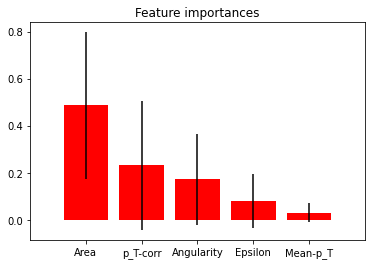

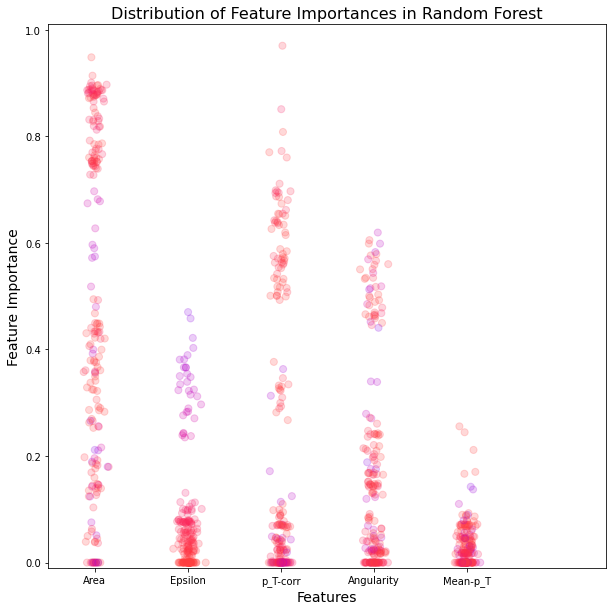

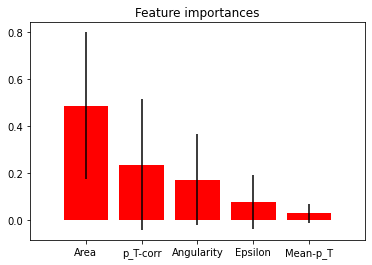

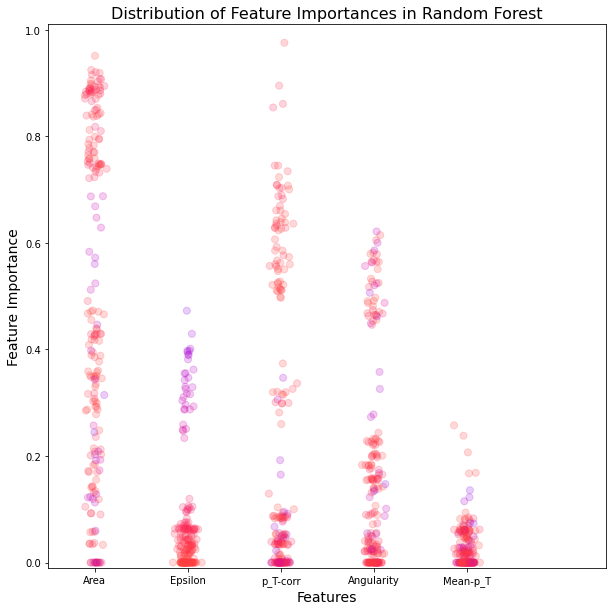

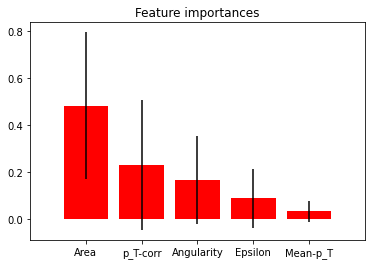

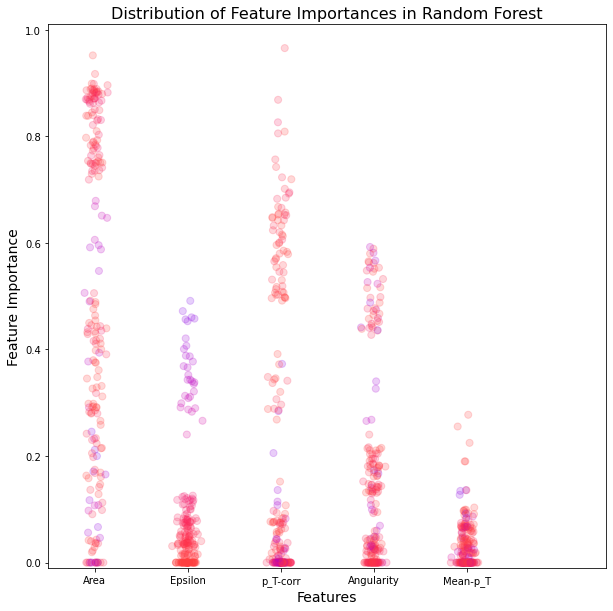

In [12]:
feat_imps = []
for model in rfModel:
    feat_imp = {}
    doModelEvaluation(X, Y, Xtest, Ytest, model, rad, ptm, feat_imp)
    feat_imps.append(feat_imp)
print(feat_imps)

JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.531216)
2. Angularity (0.278447)
3. p_T-corr (0.086691)
4. Mean-p_T (0.077252)
5. Epsilon (0.026394)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
Number of Real Jets train: 56678
Number of Fake Jets train: 388338
56678 [    0     3     4 ... 56671 56673 56675]
Real Jet Rate train: 0.7402343060799604
Fake Jet Rate train: 0.731272757237252
Squish Jet Rate train: 0.27146217423052815
Fake predicted real train: 0.13376749120611425
Real predicted fake train: 0.0740322523730548
Number of Real Jets test: 14133
Number of Fake Jets test: 97375
14133 10462
Real Jet Rate test: 0.7402533078610345
Fake Jet Rate test: 0.7301976893453145
Squish Jet Rate test: 0.2719226420244083
Fake predicted real test: 0.13610269576379974
Real predicted fake test: 0.06927050166277507
JEB: Computing feature importances and other model statistics.
JEB: Feature 

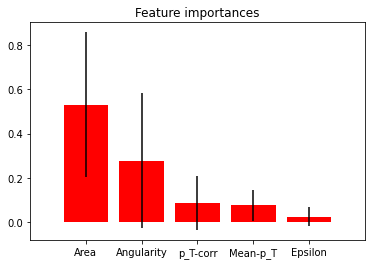

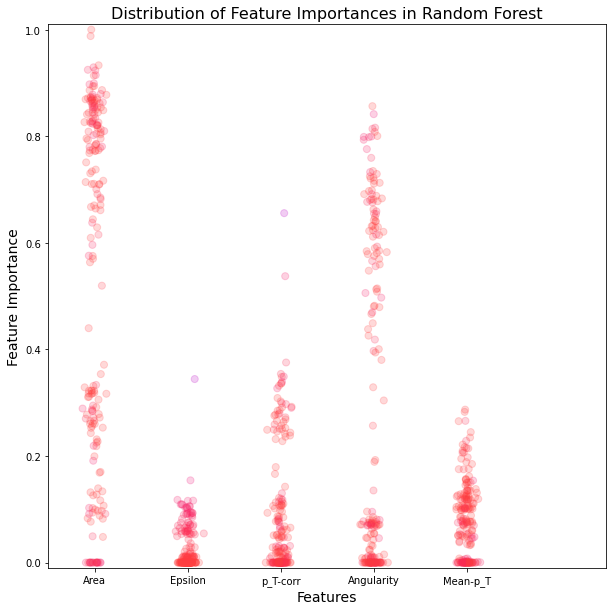

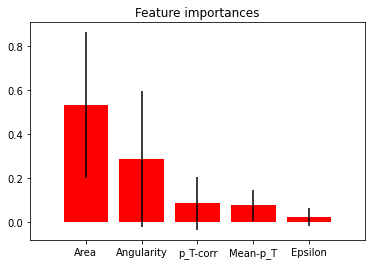

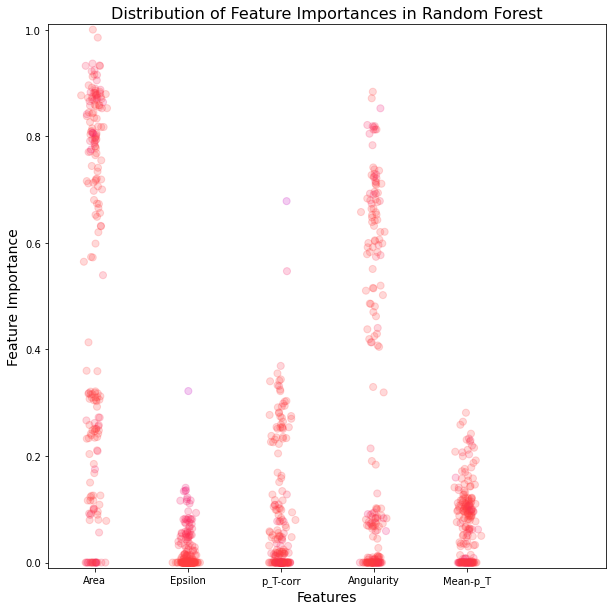

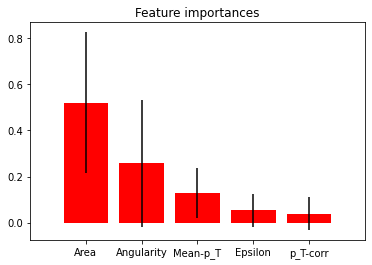

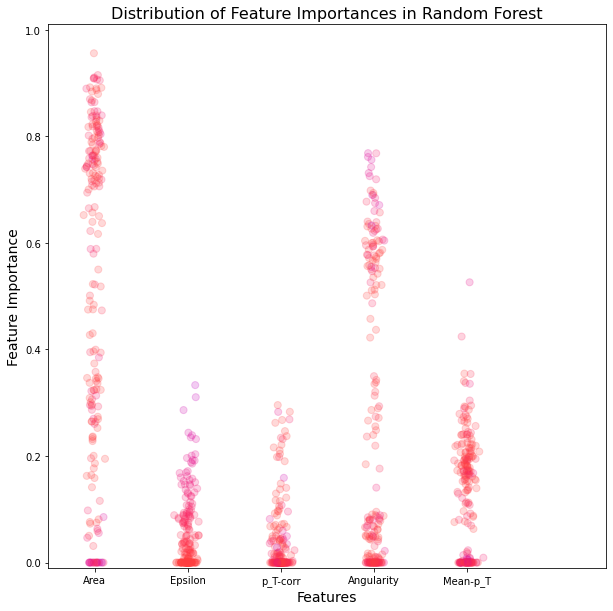

In [13]:
feat_imps_lowpt = []
for model in rfModelLowpt:
    feat_imp = {}
    doModelEvaluation(XLowpt, YLowpt, XtestLowpt, YtestLowpt, model, rad, ptm, feat_imp)
    feat_imps_lowpt.append(feat_imp)
print(feat_imps_lowpt)

In [11]:
fig.savefig('Inclusive.png')

In [12]:
fig1.savefig("lowp_T.png")

In [7]:
X, Y = split_feat_label(train)
XLowpt, YLowpt = split_feat_label(trainLowpt)
Xtest, Ytest = split_feat_label(test)

,p_T,Area,Epsilon,p_T-corr,Angularity,Mean-p_T


In [ ]:
doDataExploration(X, Y, train, rad, ptm, batch_num)
print("\n"*10)
doDataExploration(XLowpt, YLowpt, trainLowpt, rad, ptm, batch_num)


In [ ]:
rfModel = doRandomForestFit(X, Y, rfModel, batch_num)
rfModelLowpt = doRandomForestFit(XLowpt, YLowpt, rfModelLowpt, batch_num)

In [ ]:
oracle = doOracleFit(X, rfModel, rad, ptm)
oracleLowpt = doOracleFit(XLowpt, rfModelLowpt, rad, ptm, True)

JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Mean-p_T (0.261190)
2. p_T-corr (0.250142)
3. Epsilon (0.221846)
4. Area (0.196350)
5. Angularity (0.070472)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
[3 3 3 ... 3 3 3]
2853
2853 [   0    1    2 ... 2850 2851 2852]
Real Jet Rate train: 1.0
Fake Jet Rate train: 0.0
Squish Jet Rate train: 0.0
Fake predicted real train: 1.0
Real predicted fake train: 0.0
[3 3 3 ... 3 3 3]
689 689
Real Jet Rate test: 1.0
Fake Jet Rate test: 0.0
Squish Jet Rate test: 0.0
Fake predicted real test: 1.0
Real predicted fake test: 0.0


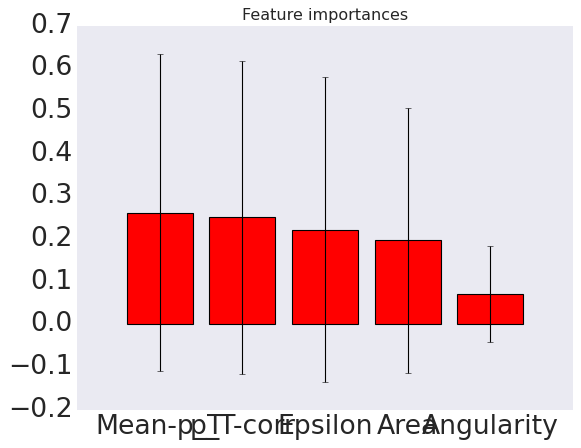

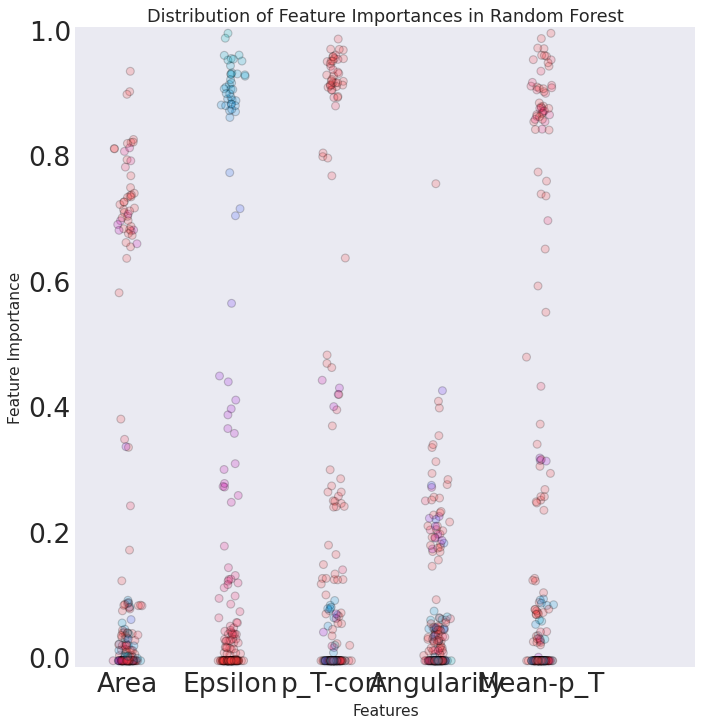

In [21]:
doModelEvaluation(X, Y, Xtest, Ytest, rfModel, rad, ptm, feat_imp)